In [9]:
folder_name = '/home/yoyo/Desktop/SimCLR/runs/facemask_Jun29_11-53-26'

In [10]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report
import importlib.util
import glob
from PIL import Image
from sklearn.manifold import TSNE

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [12]:
checkpoints_folder = os.path.join(folder_name, 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

/home/yoyo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'batch_size': 128,
 'epochs': 80,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'None',
 'log_every_n_steps': 50,
 'weight_decay': '10e-6',
 'fp16_precision': False,
 'model': {'out_dim': 128, 'base_model': 'resnet18'},
 'dataset': {'s': 1,
  'input_shape': '(96,96,3)',
  'num_workers': 0,
  'valid_size': 0.1},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [13]:
checkpoints_folder

'/home/yoyo/Desktop/SimCLR/runs/facemask_Jun29_11-53-26/checkpoints'

In [14]:
def _load_facemask(prefix="train", img_size=96):
    img_list = glob.glob('../data/facemask/' + prefix + '/**/*')
    np.random.shuffle(img_list)
    X_train = []
    for f in img_list:
        img = Image.open(f).resize((img_size, img_size))
        X_train.append(img)
    X_train = np.stack(X_train).transpose(0,3,1,2)
    y_train = np.array([f.split('/')[-2] == 'with_mask' for f in img_list])
    
    print("{} images".format(prefix))
    print(X_train.shape)
    print(y_train.shape)
    return X_train, y_train

In [15]:
# load facemask train data
X_train, y_train = _load_facemask("train")

train images
(191, 3, 96, 96)
(191,)


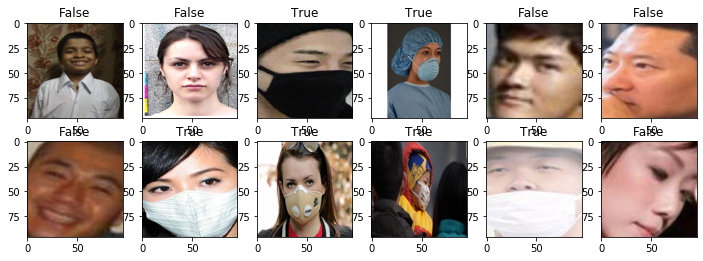

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[i].transpose(1,2,0))
    ax.title.set_text(y_train[i])
plt.show()

In [17]:
# load facemask test data
X_test, y_test = _load_facemask("test")

test images
(191, 3, 96, 96)
(191,)


## Protocol #2 Logisitc Regression

In [18]:
# Load the neural net module
spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, '../../../models/resnet_simclr.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

In [19]:
model = resnet_module.ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

Feature extractor: resnet18


In [20]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [21]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

Train features
(191, 512)


In [22]:
X_test_feature = []

for batch_x, batch_y in next_batch(X_test, y_test, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_test_feature.extend(features.cpu().detach().numpy())
    
X_test_feature = np.array(X_test_feature)

print("Test features")
print(X_test_feature.shape)

Test features
(191, 512)


In [23]:
X_embedded = TSNE(n_components=2).fit_transform(X_train_feature)
X_embedded.shape

(191, 2)

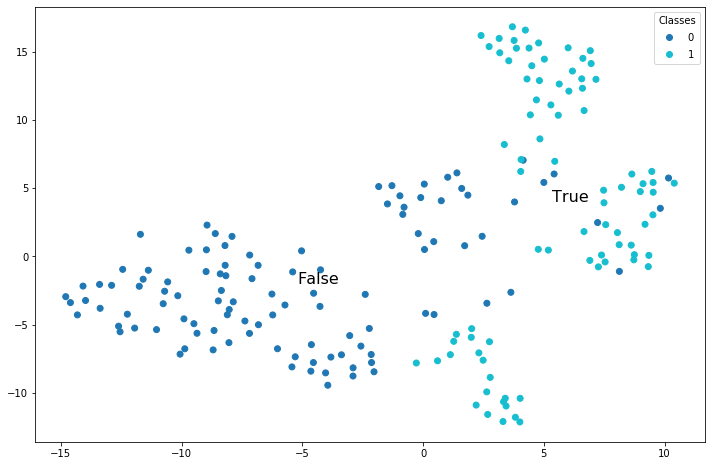

In [24]:
# Plot our dataset.
fig = plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_train, cmap='tab10')

# produce a legend with the unique colors from the scatter
plt.legend(*scatter.legend_elements(), title="Classes")

for i in np.unique(y_train):
    idx = y_train == i
    plt.text(X_embedded[idx,0].mean(), X_embedded[idx,1].mean(), i, fontsize=16)

plt.show()